In [1]:
# default_exp data.tsloader_fast

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#export
import numpy as np
import pandas as pd
import random
import torch as t
import copy
from fastcore.foundation import patch
from nixtla.data.tsdataset import TimeSeriesDataset
from collections import defaultdict

In [4]:
#export
# TODO: pensar variable shuffle para compatibilidad con dataloader de pytorch y keras
#.      por el momento tenemos solo validacion boostrapeada, no existe modo no shuffle
#.      para evaluacion no estocástica, nuestra validación está hackeada.
class TimeSeriesLoader(object):
    def __init__(self,
                 ts_dataset:TimeSeriesDataset,
                 model:str,
                 offset:int,
                 window_sampling_limit: int, 
                 input_size: int,
                 output_size: int,
                 idx_to_sample_freq: int, # TODO: Usada en hack ENORME para window frequency sampling
                 batch_size: int,
                 is_train_loader: bool,
                 shuffle:bool):
        """
        """
        # Dataloader attributes
        self.model = model
        self.window_sampling_limit = window_sampling_limit
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.idx_to_sample_freq = idx_to_sample_freq
        self.offset = offset
        self.ts_dataset = ts_dataset
        self.t_cols = self.ts_dataset.t_cols
        self.is_train_loader = is_train_loader # Boolean variable for train and validation mask
        self.shuffle = shuffle # Boolean to shuffle data, useful for validation
       
        # Create rolling window matrix in advanced for faster access to data and broadcasted s_matrix
        self._create_train_data()
        self._is_train = True # Boolean variable for train and eval mode for dataloader (random vs ordered batches)

        #TODO: mejorar estos prints
        # print('X: time series features, of shape (#series,#times,#features): \t' + str(X.shape))
        # print('Y: target series (in X), of shape (#series,#times): \t \t' + str(Y.shape))
        # print('S: static features, of shape (#series,#features): \t \t' + str(S.shape))

    def _update_sampling_windows_idxs(self):
        # Only sample during training windows with at least one active output mask
        sampling_idx = t.sum(self.ts_windows[:, self.t_cols.index('outsample_mask'), -self.output_size:], axis=1)
        sampling_idx = t.nonzero(sampling_idx > 0)
        sampling_idx = list(sampling_idx.flatten().numpy())
        # TODO: pensar como resolver el hack de +1, 
        #.      el +1 está diseñado para addressear el shift que tenemos que garantiza que el primer train tenga
        #.      por lo menos un input en la train_mask, además este código necesita la condición de que la serie más larga empieza
        #.      en el ds del que se va a querer samplear con la frecuencia particular. Hay dos hacks ENORMES.
        sampling_idx = [idx for idx in sampling_idx if (idx+1) % self.idx_to_sample_freq==0] # TODO: Esta linea muy malvada aumenta .6 segundos
        return sampling_idx

    def _create_windows_tensor(self):
        """
        Comment here
        TODO: Cuando creemos el otro dataloader, si es compatible lo hacemos funcion transform en utils
        """
        # Memory efficiency is gained from keeping across dataloaders common ts_tensor in dataset
        # Filter function is used to define train tensor and validation tensor with the offset
        # Default ts_idxs=ts_idxs sends all the data
        tensor, right_padding, train_mask = self.ts_dataset.get_filtered_ts_tensor(offset=self.offset, output_size=self.output_size,
                                                                                   window_sampling_limit=self.window_sampling_limit)
        tensor = t.Tensor(tensor)

        # Outsample mask checks existance of values in ts, train_mask mask is used to filter out validation
        # is_train_loader inverts the train_mask in case the dataloader is in validation mode
        mask = train_mask if self.is_train_loader else (1 - train_mask)
        tensor[:, self.t_cols.index('outsample_mask'), :] = tensor[:, self.t_cols.index('outsample_mask'), :] * mask

        padder = t.nn.ConstantPad1d(padding=(self.input_size-1, right_padding), value=0)
        tensor = padder(tensor)

        # Last output_size outsample_mask and y to 0
        tensor[:, self.t_cols.index('y'), -self.output_size:] = 0 # overkill to ensure no validation leakage
        tensor[:, self.t_cols.index('outsample_mask'), -self.output_size:] = 0

        # Creating rolling windows
        windows = tensor.unfold(dimension=-1, size=self.input_size + self.output_size, step=1)
        windows = windows.permute(2,0,1,3)
        windows = windows.reshape(-1, self.ts_dataset.n_channels, self.input_size + self.output_size)
        return windows

    def __len__(self):
        return len(self.len_series)

    def __iter__(self):
        #TODO: revisar como se hace el -1 de batch_size en un dataloader de torch. Otra opcion es simplemente batch_size grande,
        # tambien se puede arregar con epoca
        if self._is_train:
            if self.shuffle:
                sample_idxs = np.random.choice(a=self.windows_sampling_idx,
                                               size=len(self.windows_sampling_idx), replace=False)
            else:
                # Get last n_series windows, dataset is ordered because of unfold
                sample_idxs = self.windows_sampling_idx
        else:
            # Get last observations for each time series for last prediction
            # This is necessary because windows are created and stored in advance
            sample_idxs = list(range(self.n_windows-self.ts_dataset.n_series, self.n_windows))
        
        assert len(sample_idxs)>0, 'Check the data as sample_idxs are empty'

        n_batches = int(np.ceil(len(sample_idxs) / self.batch_size)) # Must be multiple of batch_size for paralel gpu
        
        for idx in range(n_batches):
            ws_idxs = sample_idxs[(idx * self.batch_size) : (idx + 1) * self.batch_size]
            batch = self.__get_item__(index=ws_idxs)
            yield batch

    def __get_item__(self, index):
        if self.model == 'nbeats':
            return self._nbeats_batch(index)
        elif self.model == 'esrnn':
            assert 1<0, 'hacer esrnn'
        else:
            assert 1<0, 'error'

    def _nbeats_batch(self, index):
        # Access precomputed rolling window matrix (RAM intensive)
        windows = self.ts_windows[index]
        s_matrix = self.s_matrix[index]

        insample_y = windows[:, self.t_cols.index('y'), :self.input_size]
        insample_x = windows[:, (self.t_cols.index('y')+1):self.t_cols.index('insample_mask'), :self.input_size]
        insample_mask = windows[:, self.t_cols.index('insample_mask'), :self.input_size]

        outsample_y = windows[:, self.t_cols.index('y'), self.input_size:]
        outsample_x = windows[:, (self.t_cols.index('y')+1):self.t_cols.index('insample_mask'), self.input_size:]
        outsample_mask = windows[:, self.t_cols.index('outsample_mask'), self.input_size:]

        batch = {'s_matrix': s_matrix,
                 'insample_y': insample_y, 'insample_x':insample_x, 'insample_mask':insample_mask,
                 'outsample_y': outsample_y, 'outsample_x':outsample_x, 'outsample_mask':outsample_mask}
        return batch

    def _create_train_data(self):
        """
        """
        #print('Creating windows matrix ...')
        # Create rolling window matrix for fast information retrieval
        self.ts_windows = self._create_windows_tensor()
        self.n_windows = len(self.ts_windows)
        # Broadcast s_matrix: This works because unfold in windows_tensor, padded windows, unshuffled data.
        self.s_matrix = self.ts_dataset.s_matrix.repeat(int(self.n_windows/self.ts_dataset.n_series), 1)
        self.windows_sampling_idx = self._update_sampling_windows_idxs()

    def update_offset(self, offset):
        if offset == self.offset:
            return # Avoid extra computation
        self.offset = offset
        self._create_train_data()

    def get_meta_data_col(self, col):
        return self.ts_dataset.get_meta_data_col(col)

    def get_n_variables(self):
        return self.ts_dataset.n_x, self.ts_dataset.n_s

    def get_n_series(self):
        return self.ts_dataset.n_series

    def get_max_len(self):
        return self.ts_dataset.max_len

    def get_n_channels(self):
        return self.ts_dataset.n_channels

    def get_X_cols(self):
        return self.ts_dataset.X_cols

    def get_frequency(self):
        return self.ts_dataset.frequency

    def train(self):
        self._is_train = True

    def eval(self):
        self._is_train = False

In [12]:
import matplotlib.pyplot as plt
from nixtla.data.datasets.epf import EPF, EPFInfo
Y_df, X_df = EPF.load(directory='data', group=EPFInfo.groups[0])
print("EPFInfo.groups[0]", EPFInfo.groups[0])
print("Y_df.shape", Y_df.shape)
print("X_df.shape", X_df.shape)

EPFInfo.groups[0] NP
Y_df.shape (34944, 3)
X_df.shape (34944, 12)


In [13]:
train_outsample_mask = np.ones(len(Y_df))
train_outsample_mask[-365 * 24:] = 0
print("sum(train_outsample_mask)", sum(train_outsample_mask))
epf_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df, ts_train_mask=train_outsample_mask)

sum(train_outsample_mask) 26184.0
Processing dataframes ...
Creating ts tensor ...


In [14]:
epf_dataset.ts_tensor

array([[[3.1050e+01, 3.0470e+01, 2.8920e+01, ..., 2.6820e+01,
         2.6650e+01, 2.5680e+01],
        [4.2497e+04, 4.1463e+04, 4.0812e+04, ..., 4.5471e+04,
         4.4386e+04, 4.3017e+04],
        [2.7980e+03, 2.4170e+03, 2.0360e+03, ..., 2.1290e+03,
         1.8270e+03, 1.6890e+03],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 1.0000e+00,
         1.0000e+00, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.0000e+00, ..., 1.0000e+00,
         1.0000e+00, 1.0000e+00]]])

In [53]:
ts_loader = TimeSeriesLoader(ts_dataset=epf_dataset,
                             model='nbeats',
                             offset=0,
                             window_sampling_limit=365*4*24, 
                             input_size=7*24,
                             output_size=24,
                             idx_to_sample_freq=1,
                             batch_size= 128,
                             is_train_loader=True,
                             shuffle=False)

In [54]:
dataloader = iter(ts_loader)
batch = next(dataloader)
insample_y = batch['insample_y']
insample_x = batch['insample_x']
insample_mask = batch['insample_mask']
outsample_y = batch['outsample_y']
outsample_x = batch['outsample_x']
outsample_mask = batch['outsample_mask']

print("epf_dataset.t_cols", epf_dataset.t_cols)
print("ts_loader.input_size", ts_loader.input_size)
print("ts_loader.output_size", ts_loader.output_size)
print("insample_y.shape", insample_y.shape)
print("insample_x.shape", insample_x.shape)
print("outsample_y.shape", outsample_y.shape)
print("outsample_x.shape", outsample_x.shape)

epf_dataset.t_cols ['y', 'Exogenous1', 'Exogenous2', 'week_day', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'insample_mask', 'outsample_mask']
ts_loader.input_size 168
ts_loader.output_size 24
insample_y.shape torch.Size([128, 168])
insample_x.shape torch.Size([128, 10, 168])
outsample_y.shape torch.Size([128, 24])
outsample_x.shape torch.Size([128, 10, 24])


In [55]:
# insample_y

In [56]:
# outsample_x

insample_y.shape torch.Size([128, 168])
insample_y.shape torch.Size([128, 168])
insample_y.shape torch.Size([128, 168])
check.shape (384, 168)
Checking order for unshuffled validation


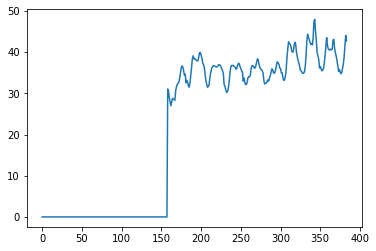

In [57]:
check_list = []
for i, batch in enumerate(ts_loader):
    insample_y = batch['insample_y']
    insample_x = batch['insample_x']
    insample_mask = batch['insample_mask']
    outsample_y = batch['outsample_y']
    outsample_x = batch['outsample_x']
    outsample_mask = batch['outsample_mask']

    #print("on_dataset.t_cols", on_dataset.t_cols)
    #print("ts_loader.input_size", ts_loader.input_size)
    #print("ts_loader.output_size", ts_loader.output_size)
    print("insample_y.shape", insample_y.shape)
    #print("insample_x.shape", insample_x.shape)
    #print("outsample_y.shape", outsample_y.shape)
    #print("outsample_x.shape", outsample_x.shape)

    check_list += [insample_y]

    if i>1: break

check = np.vstack(check_list)
print("check.shape", check.shape)
print("Checking order for unshuffled validation")
plt.plot(check[:,9])
plt.show()